### READ ME

Use the code blocks below to answer each question. Only print the output required for each question. Do not edit the comments at the top of each code cell. Otherwise, the auto-grader may misinterpret your results. See Question 0 as an an example of how to complete a task (leave it in your notebook; don't delete it):

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Question 0: Create a DataFrame with three rows and four columns. Name the 
# columns 'Col1', 'Col2', 'Col3', 'Col4'. Create an index for the DataFrame
# and give the rows the index values of 'Row1', 'Row2', 'Row3'. Place a value
# in each column equal to the {ColumnName/RowName}. e.g. Col1/Row1. Print
# the entire DataFrame.

import pandas as pd

df = pd.DataFrame(columns=['Col1', 'Col2', 'Col3', 'Col4'], index=['Row1', 'Row2', 'Row3'])

for col in df:
  for i, value in df[col].items():
    df.at[i, col] = f'{i}/{col}'

df

,Col1,Col2,Col3,Col4
Row1,Row1/Col1,Row1/Col2,Row1/Col3,Row1/Col4
Row2,Row2/Col1,Row2/Col2,Row2/Col3,Row2/Col4
Row3,Row3/Col1,Row3/Col2,Row3/Col3,Row3/Col4


In [3]:
# Question 1: Install all necessary packages here

# # !pip uninstall pandas
# # !pip install pandas==1.1.5
# !pip install pyLDAvis
# !pip install pyLDAvis.gensim
# # !pip install bokeh
# # !pip install gensim
# # !pip install spacy
# !pip install logging
# # !pip install wordcloud
# !pip install nltk
# !pip install -U pip setuptools wheel
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
# # !pip install -U seaborn
# # !pip install translators --upgrade
# # !pip install --upgrade pip

In [4]:
# Question 2: Import all necessary packages here. In addition, download
# the stopwords package from the nltk.corpus package. Set the stopwords
# list to the english version. Then, extend the stop words to include, 
# 'from', 'subject', and 'co'. You will be asked later to come back to
# this cell to add more stop words to this list.

import sys
import re
import numpy as np
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings, en_core_web_sm
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'co'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# Question 3: Import the csv that is available that was provided with this
# assignment. Print the first five records and the number of records in 
# this dataset in the output. 

# How many records are there?

import pandas as pd

df_tweets = pd.read_csv('tw_tweets_users_media_places.csv')
print(df_tweets.shape)
df_tweets

(534, 34)


,tweet_id,text,context_annotations_count,count_annotations,count_cashtags,count_hashtags,count_mentions,count_urls,created_at_tweet,lang,likes,quotes,referenced_tweet_count,replies,reply_settings,retweets,source,terms,username,created_at_author,followers_count,following_count,tweet_count,listed_count,location,protected,verified,media_type,height,width,preview_image_url,country,name_place,place_type
0,1440484799970304000,This was my grandson this morning (w/autism)! ...,1,0.0,0.0,0.0,0.0,1.0,2021-09-22T01:15:13.000Z,en,14,0,0,8,everyone,0,Twitter for Android,covid%20autism,MacRaeLady,2012-10-27T02:37:45.000Z,2709,4999,96,15,"Victoria, BC",False,False,photo,405,813,https://pbs.twimg.com/media/E_2hSs4UcAAIOK5.jpg,Canada,Langford,city
1,1439618825171963904,Wow!! Been into #York for the first time since...,2,2.0,0.0,3.0,0.0,1.0,2021-09-19T15:54:09.000Z,en,7,0,0,0,everyone,0,Twitter for iPhone,covid%20autism,zoebarratt1,2014-02-18T21:25:52.000Z,140,735,99,0,"Hessay, York",False,False,photo,2048,1536,https://pbs.twimg.com/media/E_qNsE1X0AQmoK_.jpg,United Kingdom,Hessay,city
2,1248872872837332992,Sad number of ppl who lost life due to covid-1...,3,0.0,0.0,0.0,0.0,1.0,2020-04-11T07:17:50.000Z,en,49,1,0,0,everyone,20,Twitter for iPhone,covid-19%20autistic,SteveHardyLDN,2012-01-02T10:40:18.000Z,7510,7260,100,103,"Maidstone, South East",False,False,photo,288,278,https://pbs.twimg.com/media/EVTjQcoXsAAlrfq.jpg,United Kingdom,Maidstone,city
3,1250729294051053568,Webinar now available‘Staying healthy at home ...,1,2.0,0.0,3.0,0.0,2.0,2020-04-16T10:14:35.000Z,en,3,0,0,0,everyone,1,Twitter for iPhone,coronavirus%20autism,SteveHardyLDN,2012-01-02T10:40:18.000Z,7510,7260,100,103,"Maidstone, South East",False,False,photo,2048,2048,https://pbs.twimg.com/media/EVt7pYTXkAMGzxj.jpg,United Kingdom,Maidstone,city
4,1249612131433095168,Webinar now available‘Staying healthy at home ...,1,2.0,0.0,3.0,0.0,2.0,2020-04-13T08:15:23.000Z,en,15,2,0,0,everyone,21,Twitter for iPhone,coronavirus%20autism,SteveHardyLDN,2012-01-02T10:40:18.000Z,7510,7260,100,103,"Maidstone, South East",False,False,photo,2048,2048,https://pbs.twimg.com/media/EVeDlp7X0AMuN6X.jpg,United Kingdom,Maidstone,city
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,1377395135898656768,Save The Date! Returning this year is is our @...,0,0.0,0.0,0.0,0.0,1.0,2021-03-31T22:59:25.000Z,en,12,0,0,1,everyone,6,Twitter for iPhone,"""social distancing""%20autism",HuntsPointVLTRS,2018-08-16T20:05:28.000Z,284,124,1285,0,NaN,False,False,photo,1024,686,https://pbs.twimg.com/media/Ex19kv4WUAI8WkG.jpg,United States,NYPD - 41st Precinct,poi
530,1303435852551462912,"Join SAFE, Paws For A Cause 4 Autism and All O...",1,0.0,0.0,0.0,0.0,1.0,2020-09-08T20:51:38.000Z,en,1,0,0,0,everyone,1,Twitter for iPhone,"""social distancing""%20autism",autism_SAFE,2016-08-23T20:19:35.000Z,354,370,97,5,"Plains, PA",False,False,photo,2048,1582,https://pbs.twimg.com/media/Eha7_r_WkAACJDK.jpg,United States,Hilldale,city
531,1246527727563345920,Today we have two reasons for celebration. Fir...,10,2.0,0.0,0.0,0.0,1.0,2020-04-04T19:59:04.000Z,en,1,0,0,0,everyone,0,Twitter for Android,"""social distancing""%20autism",patrykfaff,2011-06-11T00:52:58.000Z,9,28,43,0,NaN,False,False,photo,2048,1152,https://pbs.twimg.com/media/EUyOW1JXgAEnGWZ.jpg,United Kingdom,Middleton,city
532,1239010870128041984,A young adult with autism recently asked me wh...,4,0.0,0.0,1.0,0.0,1.0,2020-03-15T02:09:45.000Z,en,12,3,0,2,everyone,0,Twitter for iPhone,"""social distancing""%20autism",tlricetti,2008-09-10T23:02:28.000Z,305,313,1831,13,NaN,False,False,animated_gif,540,540,https://pbs.twimg.com/tweet_video_thumb/ETHZ0T...,United States,Napa,city


In [6]:
# Question 4: Remove line breaks, single quotes, double quotes, email 
# addresses, and tokenize each string. Convert each tweet to a list
# of cleaned words and add to a master list. Print out the first five
# cleaned tweets in the list.

def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\\S*@\\S*\\s?', '', sent)  # remove emails
        sent = re.sub('\\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert each tweet to a list of cleaned words and add to a master list
data = df_tweets.text.values.tolist()
data_words = list(sent_to_words(data))
for tweet in data_words[:5]: # print the first :n tweet word lists
  print(tweet)

['this', 'was', 'my', 'grandson', 'this', 'morning', 'autism', 'apparently', 'he', 'is', 'going', 'through', 'bout', 'of', 'bronchitis', 'amp', 'pneumonia', 'he', 'always', 'gets', 'it', 'every', 'year', 'my', 'daughter', 'said', 'that', 'she', 'is', 'sure', 'she', 'will', 'have', 'to', 'take', 'him', 'to', 'the', 'hospital', 'tonight', 'but', 'if', 'they', 'try', 'to', 'test', 'him', 'for', 'covid', 'she', 'will', 'walk', 'out', 'https', 'co', 'krqjit']
['wow', 'been', 'into', 'york', 'for', 'the', 'first', 'time', 'since', 'christmas', 'shopping', 'in', 'dec', 'took', 'our', 'daughter', 'cerys', 'to', 'the', 'catcafe', 'to', 'celebrate', 'her', 'th', 'birthday', 'perfectly', 'relaxed', 'quiet', 'covid', 'unfriendly', 'and', 'autism', 'friendly', 'she', 'was', 'in', 'her', 'happy', 'place', 'https', 'co', 'qzck', 'fze']
['sad', 'number', 'of', 'ppl', 'who', 'lost', 'life', 'due', 'to', 'covid', 'is', 'far', 'more', 'than', 'the', 'number', 'that', 'it', 'says', 'on', 'the', 'news', 't

In [7]:
# Question 5: Build bigram and trigram models. Remove Stopwords, form 
# Bigrams, Trigrams and perform Lemmatization. Use a threshold of 100 and 
# a min_count of 5. Print the results of the first three clean tweets
# before being lemmatized and after being lemmatized.

# What does lemmatization do?
# ANSWER: Lemmitization is the process of converting a word to its base form

# What's the difference in length of the first tweet before and after being lemmatized?

# print the length of the first tweet before and after being lemmatized
print('Length before Lemm: ' + str(len(data_words[0])))

# Build bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=10)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Remove stopwords / add bigrams, trigrams / perform Lemmatization
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  # Remove stopwords, form bigrams and trigrams, and perform Lemmatization
  texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
  texts = [bigram_mod[doc] for doc in texts]
  texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
  
  texts_out = []
  nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])    # Load spacy, but we don't need the parser or NER (named entity extraction) modules
  
  for sent in texts:
    doc = nlp(" ".join(sent)) 
    texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
      
  # remove stopwords once more after lemmatization
  texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
  return texts_out

data_ready = process_words(data_words)  # processed Text Data!
for tweet in data_ready[:5]:
  print(tweet)

print('Length after Lemm: ' + str(len(data_words[0])))


Length before Lemm: 56


/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['grandson', 'morning', 'autism', 'apparently', 'go', 'bout', 'always', 'get', 'year', 'daughter', 'say', 'take', 'hospital', 'tonight', 'try', 'test', 'covid', 'walk']
['first', 'time', 'shopping', 'take', 'daughter', 'cery', 'catcafe', 'celebrate', 'birthday', 'perfectly', 'relaxed', 'quiet', 'covid', 'unfriendly', 'autism', 'friendly', 'happy', 'place', 'qzck']
['sad', 'number', 'ppl', 'lose', 'life', 'due', 'covid', 'far', 'number', 'say', 'news', 'pass', 'away', 'care', 'home', 'support', 'live', 'community', 'count', 'give', 'think', 'amp', 'life', 'matter']
['webinar', 'available', 'stay', 'healthy', 'home', 'coronavirus', 'crisis', 'deliver', 'hardy', 'socialcare', 'dkoxg', 'sjrm']
['webinar', 'available', 'stay', 'healthy', 'home', 'coronavirus', 'crisis', 'deliver', 'hardy', 'socialcare', 'auevngqt']
Length after Lemm: 56


In [8]:
# Question 6: Create a dictionary and courpus and build your LDA 
# model using 4 topics. Set the random_state to 12345. Set the
# chuncksize to 20, passes to 10, and per_word_topics to True. Do not
# set or adjust any other parameters (even if the example in the 
# book does). Print out the topic weights for the 10 most important
# words in each topic.

# What weight does the term "autism" have on Topic 0?

# Create Dictionary then create Corpus
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

# Change the number of topics in the LDA here
topics = 6
num_topics = topics

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=topics,
                                            random_state=12345,
                                            chunksize=20,
                                            passes=10,
                                            per_word_topics=True)

ldatopics = lda_model.show_topics(formatted=False)
pprint(lda_model.print_topics())

[(0,
  '0.031*"get" + 0.030*"go" + 0.028*"autism" + 0.019*"autistic" + '
  '0.017*"covid" + 0.016*"year" + 0.016*"school" + 0.015*"hard" + '
  '0.014*"really" + 0.014*"love"'),
 (1,
  '0.040*"people" + 0.027*"need" + 0.026*"child" + 0.019*"month" + '
  '0.018*"work" + 0.017*"young" + 0.016*"son" + 0.013*"autistic" + '
  '0.013*"well" + 0.012*"covid"'),
 (2,
  '0.064*"autism" + 0.039*"amp" + 0.036*"coronavirus" + 0.032*"support" + '
  '0.020*"covid" + 0.018*"family" + 0.017*"new" + 0.014*"community" + '
  '0.013*"learn" + 0.011*"long"'),
 (3,
  '0.030*"quarantine" + 0.022*"want" + 0.017*"autism" + 0.016*"sensory" + '
  '0.013*"overload" + 0.012*"much" + 0.012*"shirt" + 0.010*"especially" + '
  '0.010*"start" + 0.010*"let"'),
 (4,
  '0.045*"lockdown" + 0.039*"day" + 0.028*"autism" + 0.024*"today" + '
  '0.018*"friend" + 0.014*"thing" + 0.014*"good" + 0.013*"house" + '
  '0.012*"https" + 0.012*"put"'),
 (5,
  '0.038*"pandemic" + 0.025*"help" + 0.025*"make" + 0.020*"take" + '
  '0.017*"tim

In [9]:
# Question 7: Generate LDA models for n = 3 through 9 topics and compare their perplexity 
# and coherence scores. Keep all other parameter settings used in the prior question.

# What are the values for perplexity and coherence of a
# model with n=4 topics?

df_fit = pd.DataFrame(columns=['num_topics', 'perplexity', 'coherence'])

for n in range(3,9):
  # Fit LDA model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                              id2word=id2word, 
                                              num_topics=n, 
                                              random_state=12345,
                                              chunksize=20, 
                                              passes=10,
                                              per_word_topics=True)

  # Generate fit metrics
  coherence_model_lda = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
  
  # Add metrics to df_fit
  df_fit.loc[n - 3] = [n, round(lda_model.log_perplexity(corpus), 3), round(coherence_model_lda.get_coherence(), 3)]

# df_fit['diff'] = abs(df_fit.coherence - df_fit.perplexity)
df_fit


,num_topics,perplexity,coherence
0,3.0,-7.798,0.318
1,4.0,-7.970,0.351
2,5.0,-8.099,0.322
3,6.0,-8.179,0.366
4,7.0,-8.284,0.416
5,8.0,-8.322,0.429


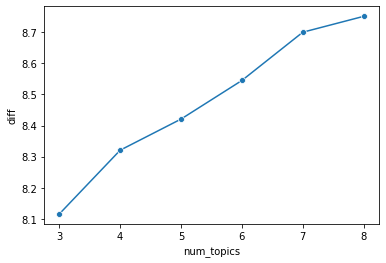

In [10]:
# Question 8: Visualize results of comparing the perplexity/coherence from the previous
# question. 

# How many topics gives you the greatest difference?

import seaborn as sns

df_fit['diff'] = abs(df_fit.coherence - df_fit.perplexity)
sns.lineplot(x='num_topics', y='diff', data=df_fit, ci=None, marker='o');


In [11]:
# Question 9: Generate new features (one for each topic) and then generate a 
# topic score for every document. Nine topics will give us results with 
# underrepresented and uneven topics, so for now let's use five topics. 
# Keep all other parameter settings used in the prior question.

# What is the dominant topic score of topic_1 for the first tweet 
# (tweet_id 1440484799970304000) in your dataset?
# Note: Answer this question before eliminating words in question 12

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                      id2word=id2word, 
                                      num_topics=5, 
                                      random_state=12345,
                                      chunksize=100, 
                                      passes=5,
                                      per_word_topics=True)

df_topics = df_tweets.copy()

num_topics = len(lda_model.get_topics()) # store the number of topics from the last model
for col in range(num_topics): # generate a new column for each topic
  df_topics[f'topic_{col + 1}'] = 0.0
  
# Store the topic score and dominant topic
for i, words in enumerate(data_ready):
  doc = lda_model[id2word.doc2bow(words)] # generate a corpus for this document set of words
  
  for j, score in enumerate(doc[0]): # for each document in the corpus
    # Get the topic score and store it in the appropriate column
    df_topics.iat[i, (len(df_topics.columns) - ((num_topics) - score[0]))] = score[1]

df_topics.head()

,tweet_id,text,context_annotations_count,count_annotations,count_cashtags,count_hashtags,count_mentions,count_urls,created_at_tweet,lang,likes,quotes,referenced_tweet_count,replies,reply_settings,retweets,source,terms,username,created_at_author,followers_count,following_count,tweet_count,listed_count,location,protected,verified,media_type,height,width,preview_image_url,country,name_place,place_type,topic_1,topic_2,topic_3,topic_4,topic_5
0,1440484799970304000,This was my grandson this morning (w/autism)! ...,1,0.0,0.0,0.0,0.0,1.0,2021-09-22T01:15:13.000Z,en,14,0,0,8,everyone,0,Twitter for Android,covid%20autism,MacRaeLady,2012-10-27T02:37:45.000Z,2709,4999,96,15,"Victoria, BC",False,False,photo,405,813,https://pbs.twimg.com/media/E_2hSs4UcAAIOK5.jpg,Canada,Langford,city,0.570254,0.010791,0.010660,0.143853,0.264443
1,1439618825171963904,Wow!! Been into #York for the first time since...,2,2.0,0.0,3.0,0.0,1.0,2021-09-19T15:54:09.000Z,en,7,0,0,0,everyone,0,Twitter for iPhone,covid%20autism,zoebarratt1,2014-02-18T21:25:52.000Z,140,735,99,0,"Hessay, York",False,False,photo,2048,1536,https://pbs.twimg.com/media/E_qNsE1X0AQmoK_.jpg,United Kingdom,Hessay,city,0.010116,0.010031,0.010080,0.010016,0.959758
2,1248872872837332992,Sad number of ppl who lost life due to covid-1...,3,0.0,0.0,0.0,0.0,1.0,2020-04-11T07:17:50.000Z,en,49,1,0,0,everyone,20,Twitter for iPhone,covid-19%20autistic,SteveHardyLDN,2012-01-02T10:40:18.000Z,7510,7260,100,103,"Maidstone, South East",False,False,photo,288,278,https://pbs.twimg.com/media/EVTjQcoXsAAlrfq.jpg,United Kingdom,Maidstone,city,0.866747,0.000000,0.109054,0.000000,0.000000
3,1250729294051053568,Webinar now available‘Staying healthy at home ...,1,2.0,0.0,3.0,0.0,2.0,2020-04-16T10:14:35.000Z,en,3,0,0,0,everyone,1,Twitter for iPhone,coronavirus%20autism,SteveHardyLDN,2012-01-02T10:40:18.000Z,7510,7260,100,103,"Maidstone, South East",False,False,photo,2048,2048,https://pbs.twimg.com/media/EVt7pYTXkAMGzxj.jpg,United Kingdom,Maidstone,city,0.015422,0.015389,0.938304,0.015490,0.015394
4,1249612131433095168,Webinar now available‘Staying healthy at home ...,1,2.0,0.0,3.0,0.0,2.0,2020-04-13T08:15:23.000Z,en,15,2,0,0,everyone,21,Twitter for iPhone,coronavirus%20autism,SteveHardyLDN,2012-01-02T10:40:18.000Z,7510,7260,100,103,"Maidstone, South East",False,False,photo,2048,2048,https://pbs.twimg.com/media/EVeDlp7X0AMuN6X.jpg,United Kingdom,Maidstone,city,0.016710,0.016670,0.933152,0.016791,0.016677


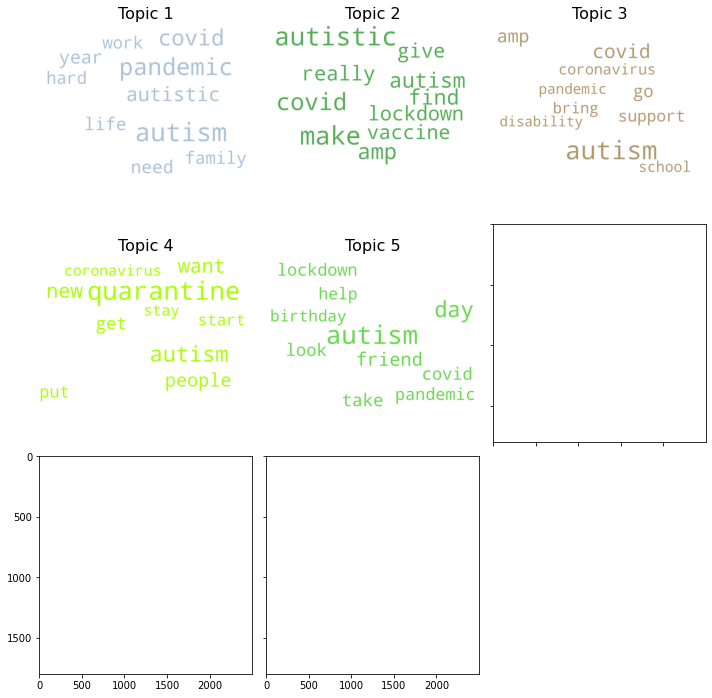

In [12]:
# Question 10: Create a wordcloud of Top N words in each topic. Copy the 
# parameter settings for the WordCloud object that are used in the book.

# What word appears in every word cloud?

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors, math

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS', fewer colors: 'mcolors.TABLEAU_COLORS'

cloud = WordCloud(stopwords=stop_words,
                    background_color='white',
                    width=2500,
                    height=1800,
                    max_words=20,
                    colormap='tab10',
                    color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    try:
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
      plt.gca().axis('off')
    except:
      continue


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

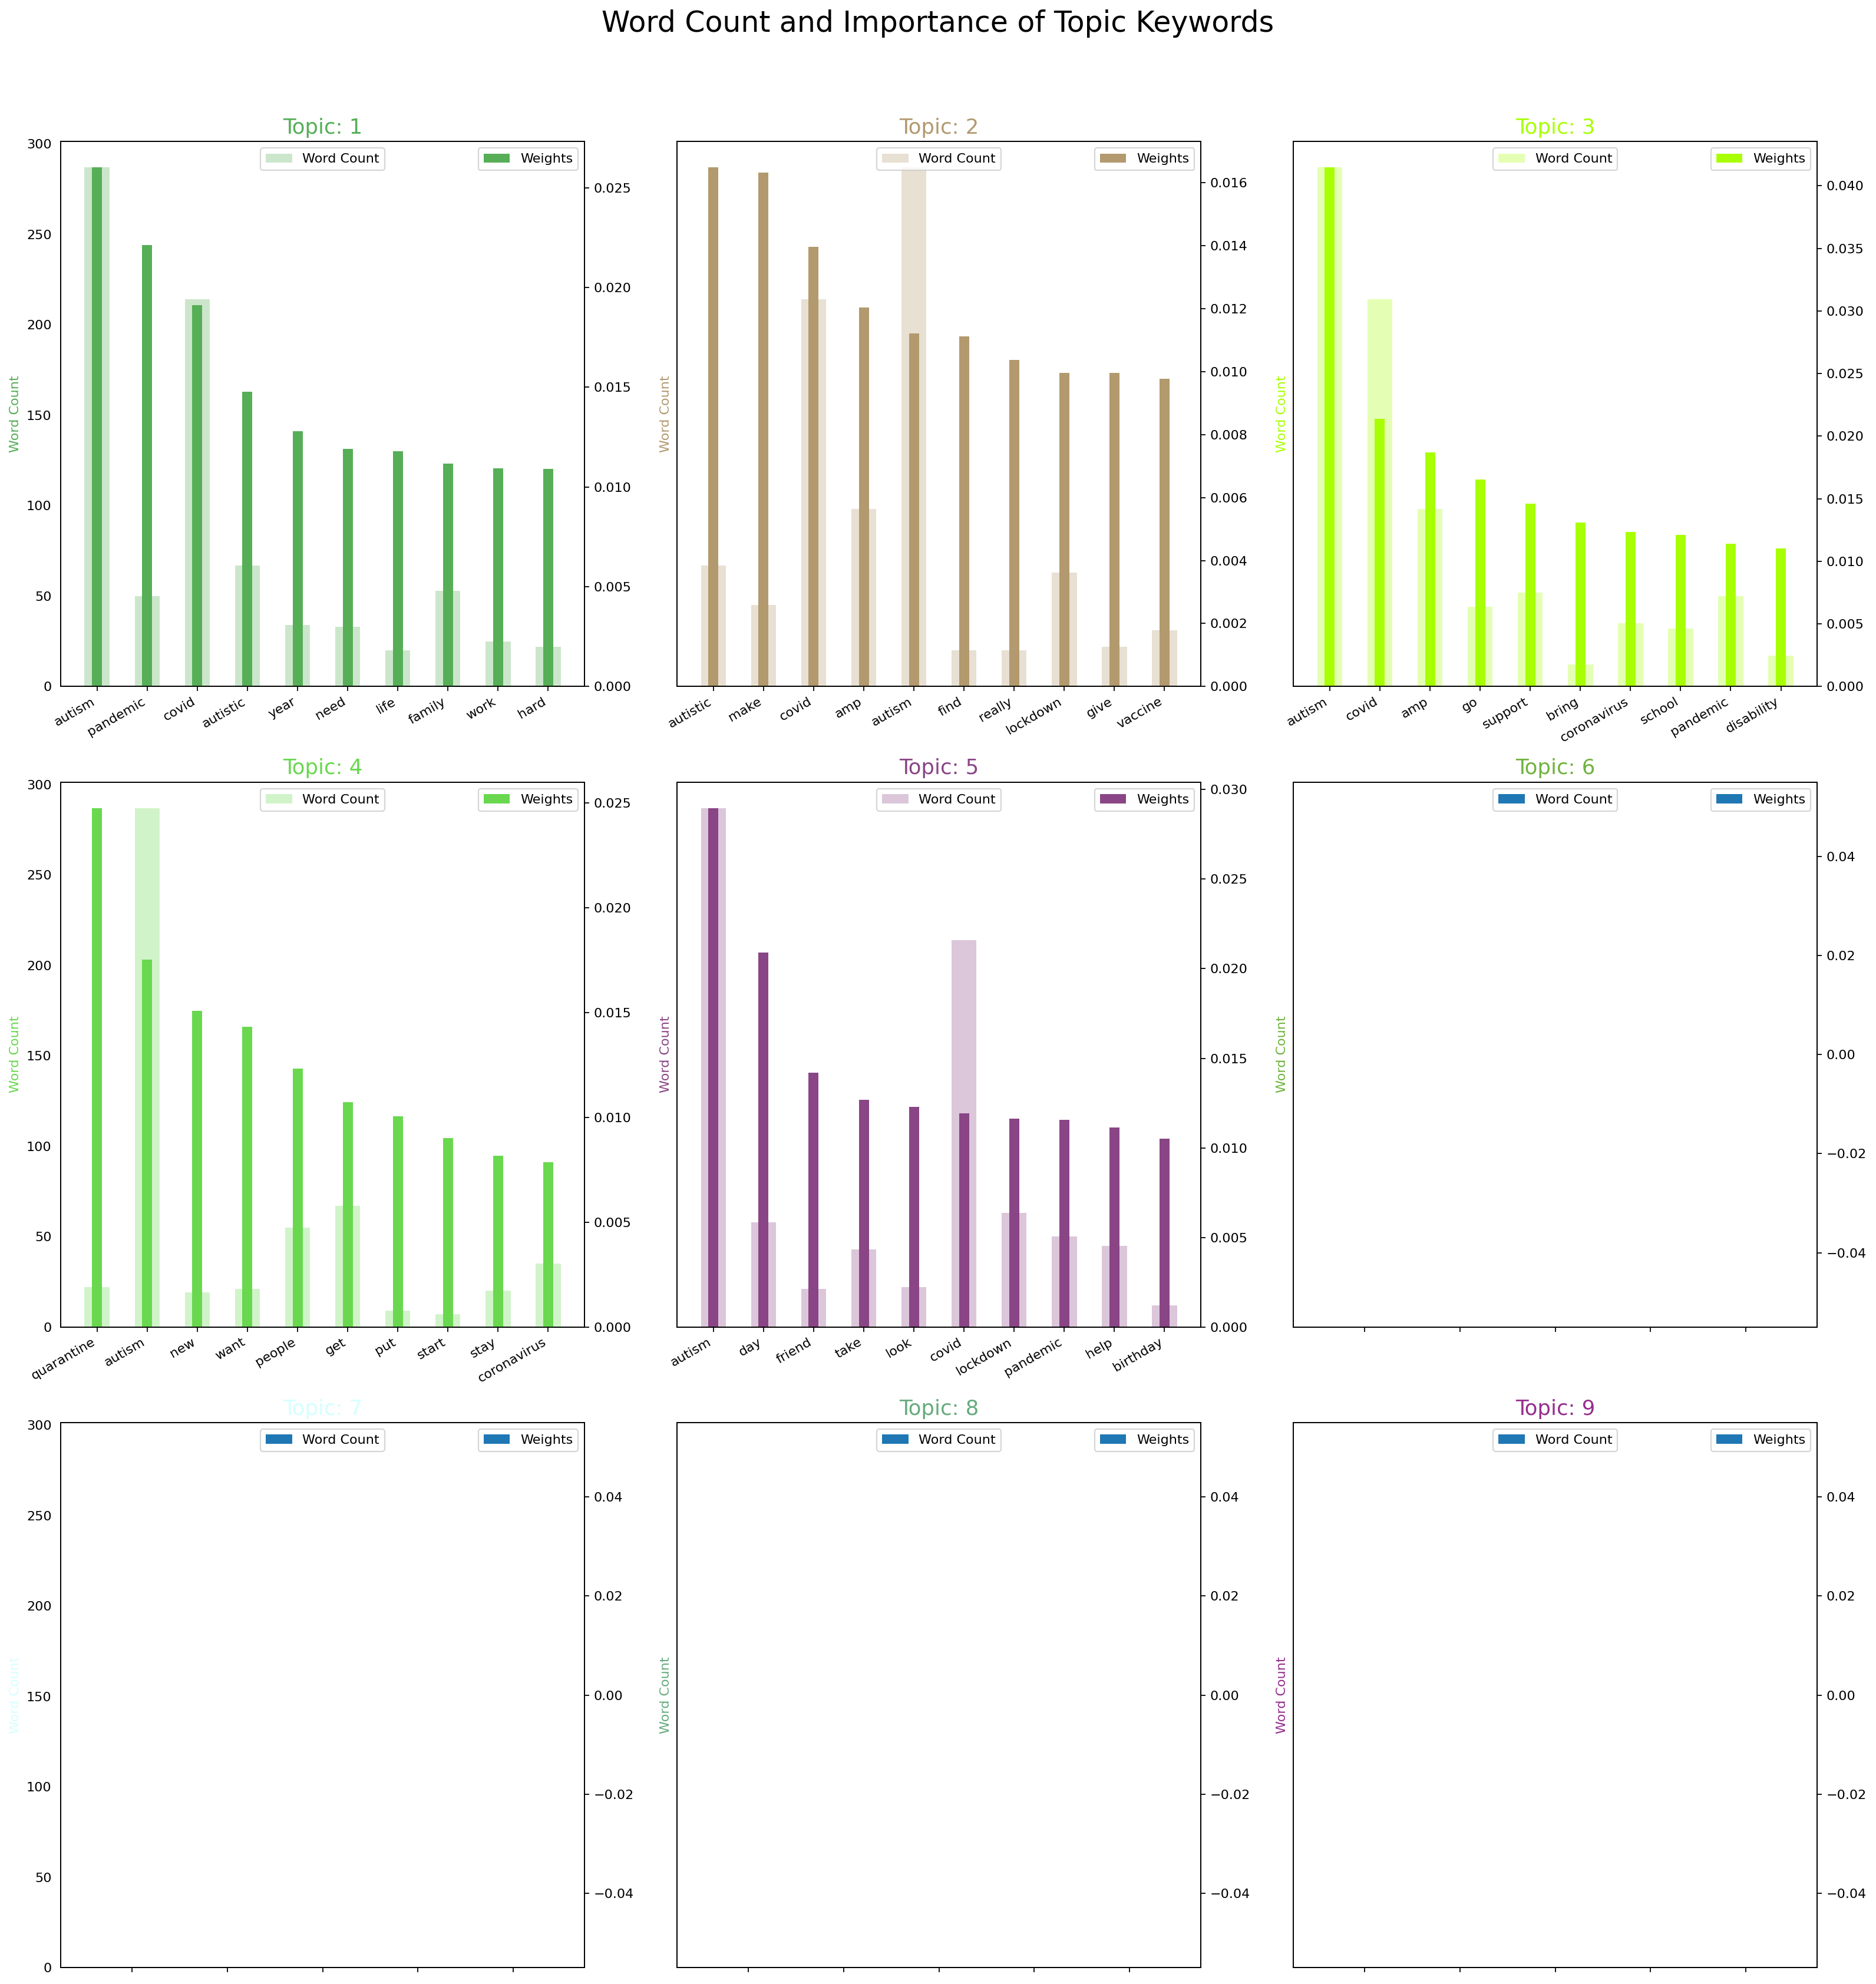

In [13]:
# Question 11:
# Create a bar chart of word counts for all five topics. Plot Word Count and Weights
# of Topic Keywords. Which of the words below should be added to the stop words list?

from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i + 1, weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(math.ceil(num_topics**(1/2)), math.ceil(num_topics**(1/2)), figsize=(20,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i+1, :], color=cols[i+1], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i+1, :], color=cols[i+1], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i+1])
    # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i + 1), color=cols[i+1], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i+1, 'word'], rotation=30, horizontalalignment= 'right')
    try:
      ax.legend(loc='upper center'); ax_twin.legend(loc='upper right')
    except:
      pass

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [14]:
# Question 13:
# Visualize the number of documents/tweets attributed to each topic is through
# a t-distributed Stochastic Neighbor Embedding (SNE) chart. 

# Based on this chart, does it appear that every tweet was properly assigned 
# to the most appropriate topic?

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 529 samples in 0.001s...
[t-SNE] Computed neighbors for 529 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 529 / 529
[t-SNE] Mean sigma: 0.108657
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.132587
[t-SNE] KL divergence after 1000 iterations: 0.309948


In [15]:
# Question 14:
# Print out an interactive visualization with pyLDAvis.

# Which topic appears to be most related to needing help and support?

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.121113 -0.012276       1        1  22.941399
2      0.057650 -0.180230       2        1  21.186535
4      0.019457  0.087266       3        1  20.874931
1      0.022285  0.137505       4        1  20.638566
3     -0.220506 -0.032265       5        1  14.358568, topic_info=            Term       Freq       Total Category  logprob  loglift
95    quarantine  28.000000   28.000000  Default  30.0000  30.0000
115          day  48.000000   48.000000  Default  29.0000  29.0000
33           amp  56.000000   56.000000  Default  28.0000  28.0000
173       friend  23.000000   23.000000  Default  27.0000  27.0000
634          new  17.000000   17.000000  Default  26.0000  26.0000
..           ...        ...         ...      ...      ...      ...
2         autism  19.610320  199.696095   Topic5  -4.0440  -0.3799
54   coronavirus   8.781403   30.138885   Topic5  -4.8474   0.7076
199     autistic   6.726281   61.540445   Topic5  -5.1140  -0.2728
92          much   5.399089   14.306041   Topic5  -5.3338   0.9664
204         need   5.399924   33.562308   Topic5  -5.3336   0.1138

[274 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2467      1  0.932994  academic
2196      2  0.810175   address
2196      3  0.101272   address
672       5  0.880565      adhd
198       4  0.986110     adult
...     ...       ...       ...
216       2  0.165442      work
451       3  0.954890     world
145       1  0.935817     write
17        1  0.864957      year
17        4  0.112820      year

[314 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])